# Active online boats

## Import modules

In [1]:
%matplotlib inline
from math import ceil
import pandas as pd
import numpy as np
from pandas import DataFrame, read_sql_query
from datetime import date
from IPython.display import HTML, display

display(HTML('<p>Last update {0}</p>'.format(date.today())))

## Load data

Load all active boats with charther company is still active

In [2]:
boats_df = pd.read_csv('./data/active_boats.csv')

## Small data sample

In [3]:
boats_df.head()

,name,boat_type,length,double_cabins,wc
0,Moorings 4600 - Club,2,14.02,4,5
1,Sunsail 47/4/4 Prem Plus,1,14.33,4,4
2,Sunsation F-4,4,13.30,1,1
3,Sunsail 44i/4/2,1,13.41,4,2
4,TRAPANI VELA CLUB,1,9.67,2,1


In [4]:
display(HTML("<p><b>{0}</b> boats active onsite </p>".format(boats_df.shape[0])))

## Filter and cleaning data

We want to consider here only **sail boats** and **catamarans**

In [5]:
#available boat types
BOAT_TYPE_SAILBOAT = 1
BOAT_TYPE_CATAMARAN = 2
# BOAT_TYPE_GULET = 3
# BOAT_TYPE_POWER_BOAT = 4
# BOAT_TYPE_HOUSE_BOAT = 5
# BOAT_TYPE_LUXURY_MEGA_YACHT = 6

boats_df = boats_df[boats_df.boat_type.isin((BOAT_TYPE_SAILBOAT, BOAT_TYPE_CATAMARAN))]

In [6]:
# let's convert length from meter to feet
boats_df.length = boats_df['length'].apply(lambda x: int(x * 3.280))
boats_df.head()

,name,boat_type,length,double_cabins,wc
0,Moorings 4600 - Club,2,45,4,5
1,Sunsail 47/4/4 Prem Plus,1,47,4,4
3,Sunsail 44i/4/2,1,43,4,2
4,TRAPANI VELA CLUB,1,31,2,1
5,Sunsail 47/4/4 Prem,1,47,4,4


In [7]:
boats_df.describe()

,boat_type,length,double_cabins,wc
count,7050.000000,7050.000000,7050.000000,7050.000000
mean,1.250071,42.519716,3.548085,2.483830
std,0.433084,6.821475,0.896724,1.246169
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,38.000000,3.000000,2.000000
50%,1.000000,42.000000,4.000000,2.000000
75%,1.750000,46.000000,4.000000,3.000000
max,2.000000,131.000000,20.000000,21.000000


We see here there are boats with lenght zero, no double cabins and no toilets: this boats are unuseful for us to make a prediction. 

Let's get rid of all of them:

In [8]:
boats_df = boats_df[boats_df.length > 0]
boats_df = boats_df[boats_df.double_cabins > 0]
boats_df = boats_df[boats_df.wc > 0]

## Prediction model

We want to predic how many toiles a boats should have based on number of double cabins and boat type

In [9]:
# input 
feature = ['boat_type', 'length', 'double_cabins']
X = boats_df[feature]
# target 
y = boats_df[['wc']]

## Decision Tree

In [10]:
from sklearn import tree

MAX_DEPTH=3

clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
clf = clf.fit(X, y)

### Visualize Decision tree

In [21]:
from sklearn.externals.six import StringIO
with open("boat_tree.dot", 'w') as f:
  f = tree.export_graphviz(clf, out_file=f, feature_names=feature)

In [22]:
# ! apt-get update; apt-get install graphviz -y; dot -Tpng boat_teee.dot -o boat_teee.png
! dot -Tpng boat_tree.dot -o boat_tree.png

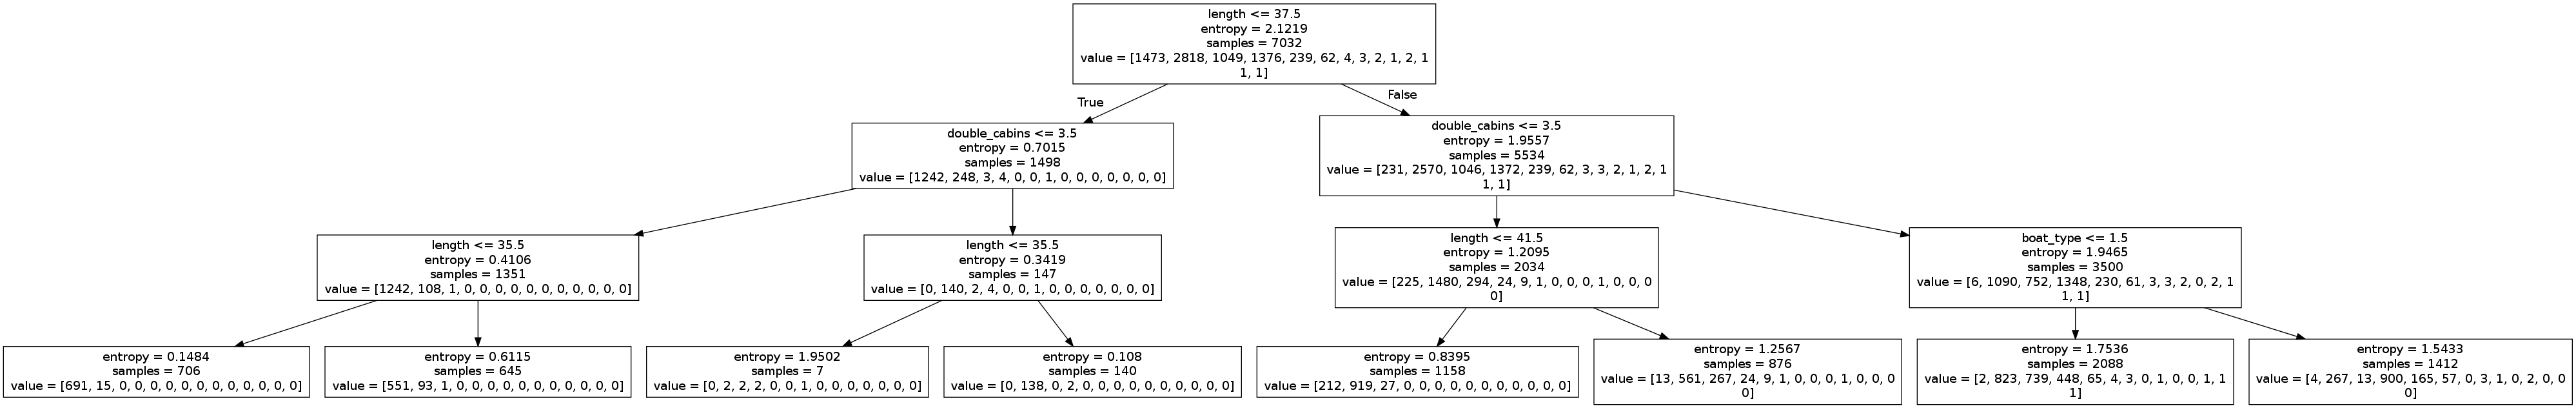

In [23]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("boat_tree.png")

## Cross Validation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf_2 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
clf_2 = clf_2.fit(X_train, y_train)

In [15]:
# predict class labels for the test set
predicted = clf_2.predict(X_test)
print(predicted)

[3 2 1 ..., 1 3 2]


In [16]:
# generate class probabilities
probs = clf_2.predict_proba(X_test)
print(probs)

[[ 0.00206825  0.15305067  0.47569804 ...,  0.00103413  0.00103413
   0.00103413]
 [ 0.18708827  0.79841897  0.01449275 ...,  0.          0.          0.        ]
 [ 0.97580645  0.02419355  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.97580645  0.02419355  0.         ...,  0.          0.          0.        ]
 [ 0.00206825  0.15305067  0.47569804 ...,  0.00103413  0.00103413
   0.00103413]
 [ 0.          0.87941788  0.11226611 ...,  0.          0.          0.        ]]


In [17]:
# generate evaluation metrics
accuracy = metrics.accuracy_score(y_test, predicted)
#print(metrics.roc_auc_score(y_test, probs[:, 1]))


In [18]:
display(HTML("<p>The model we built has a <b>{0}%</b> to predict correclty new sample</p>".format(
            round(accuracy * 100, 2))))

## Persist the model

In [19]:
from sklearn.externals import joblib
joblib.dump(clf, 'decision_tree.pkl') 

['decision_tree.pkl']